In [1]:
# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing imports
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

## Import data

In [2]:
df = pd.read_csv("my_data/groove-bottom.csv")
df

,x,y,z,groove,tread,depth,bottom
0,0.15000,-0.12917,0.42000,-1,True,2.252963,False
1,0.15000,-0.12917,0.42000,-1,True,2.252963,False
2,0.14988,-0.12882,0.42000,-1,True,2.539181,False
3,0.14988,-0.12882,0.42000,-1,True,2.539181,False
4,0.14882,-0.13181,0.41882,-1,True,1.286047,False
...,...,...,...,...,...,...,...
195176,-0.13118,0.02294,0.27167,2,False,3.290156,False
195177,-0.13118,0.02287,0.27176,2,False,3.393917,False
195178,-0.13000,0.02287,0.27176,2,False,3.116971,False
195179,-0.12412,0.02271,0.27176,2,False,3.018646,False


## Plot depth histograms

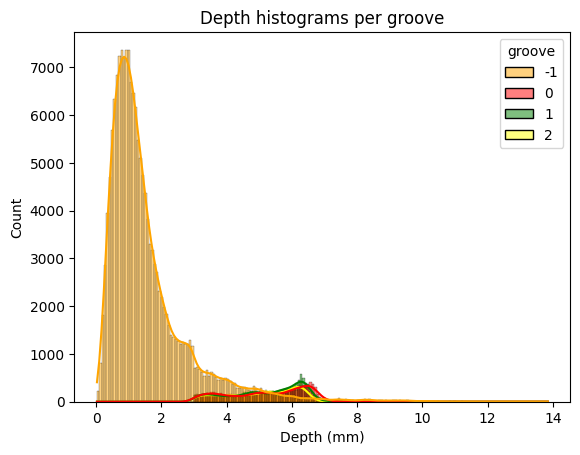

In [3]:
# Create color palette
colors = ["orange", "red", "green", "yellow"]
palette = {g: c for g, c in zip(df.groove.unique(), colors)}

# Plot the data
plt.title("Depth histograms per groove")
sns.histplot(data=df, x="depth", hue="groove", kde=True, palette=palette)
plt.xlabel("Depth (mm)")
plt.show()

From this plot, we can see that both the tread and the groove data have peaks at different depths. These peaks likely correspond to the tread and groove bottom depths, where the point cloud is more densely populated.

Let's isolate the bottom of each groove and look at their depth distributions to visually check this:

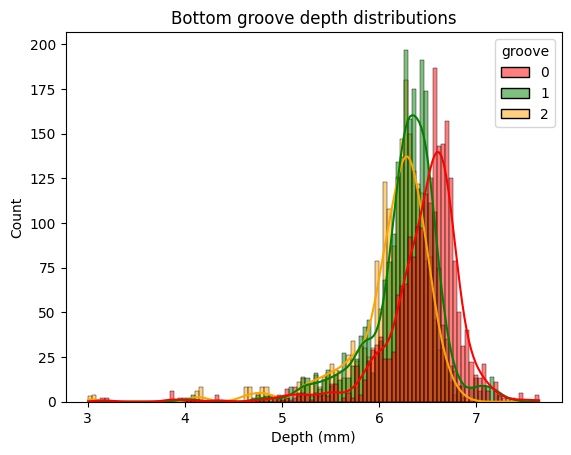

In [4]:
# Filter dataframe to groove bottoms
bottom_df = df.query("bottom")

# Define color palette
colors = ["red", "green", "orange"]
palette = {g: c for g, c in zip(bottom_df.groove.unique(), colors)}

# Plot the histograms
plt.title("Bottom groove depth distributions")
sns.histplot(bottom_df, x="depth", hue="groove", kde=True, palette=palette)
plt.xlabel("Depth (mm)")
plt.show()

With this plot, we can clearly see that the peaks of the groove distributions represent the depth of the bottom of the grooves. They are close to normally distributed, but somewhat left skewed.

To calculate the depth of the groove bottoms, we need to subtract the groove depth by the tread depth.
We will do this in the following manner:
- Approximate histogram distributions for tread and grooves using KDE
- Sample datapoints from each groove and from tread to calculate difference distribution from groove
- Use the mean of the distribution as the predicted value of the difference
- Calculate prediction interval according to a certain significance level from the distribution

## Part 1: Approximating difference distribution per groove

In [5]:
# Define number of samples for the difference distribution
n_samples = 100000

# Initialize dictionary of difference samples
diff_df = {"groove": [], "diff": []}

# Get tread data
tread_df = df.query("tread")

# Calculate tread data KDE and samples
tread_kde = gaussian_kde(tread_df.depth)
tread_samples = tread_kde.resample(n_samples).reshape(-1)

# Get bottom of groove data
bottom_df = df.query("bottom")

# Iterate each groove
for g in bottom_df.groove.unique():
    
    # Filter groove bottom data
    groove_df = bottom_df.query(f"groove == {g}")
    
    # Calculate depth KDE and samples for groove
    groove_kde = gaussian_kde(groove_df.depth)
    groove_samples = groove_kde.resample(size=n_samples).reshape(-1)
    
    # Calculate difference samples
    diff_samples = groove_samples - tread_samples
    
    # Calculate sample difference and add data to difference dict
    grooves = g * np.ones(shape=n_samples, dtype="int64")
    diff_df["groove"].append(grooves)
    diff_df["diff"].append(diff_samples)
    
# Concatenate all samples
diff_df["groove"] = np.concatenate(diff_df["groove"])
diff_df["diff"] = np.concatenate(diff_df["diff"])
    
# Turn dictionary into dataframe
diff_df = pd.DataFrame(diff_df)
diff_df

,groove,diff
0,0,5.367030
1,0,4.987584
2,0,5.294536
3,0,6.174379
4,0,5.377190
...,...,...
299995,2,5.288397
299996,2,4.895596
299997,2,6.123259
299998,2,5.644085


Now let's plot the distribution of the depth difference for each groove:

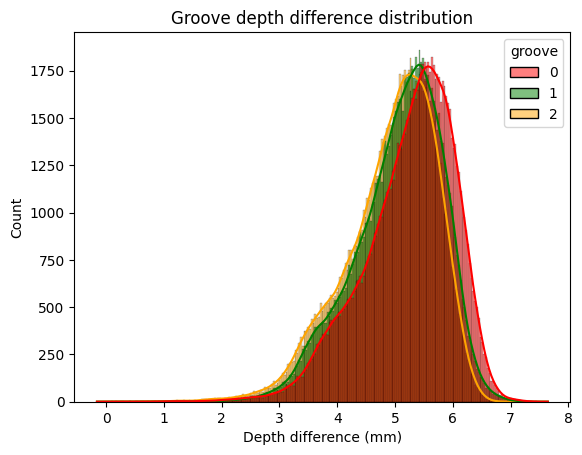

In [6]:
plt.title("Groove depth difference distribution")
sns.histplot(data=diff_df, x="diff", hue="groove", kde=True, palette=palette)
plt.xlabel("Depth difference (mm)")
plt.show()

Now we can estimate the groove depth as the mean of the distribution.

Given a significance $\alpha$, we define the prediction interval as the quantiles $\alpha/2$ and $1 - \alpha/2$:

In [7]:
# Get the mean per goove
mean_df = diff_df.groupby("groove", as_index=False).mean()
mean_df

,groove,diff
0,0,5.238417
1,1,5.055097
2,2,4.918033


In [8]:
# Define significance
significance = 0.05

# Get the prediction quantiles
interval_df = diff_df.rename(columns={"diff": "lower"})
interval_df["upper"] = interval_df["lower"]

# Get the quantiles
interval_df = interval_df.groupby("groove", as_index=False).agg({
    "lower": lambda x: np.quantile(x, significance/2),
    "upper": lambda x: np.quantile(x, 1-significance/2)
})
interval_df

,groove,lower,upper
0,0,3.476117,6.440944
1,1,3.360614,6.262708
2,2,3.138097,6.126489


Therefore, from this analysis, we can verify that the depth of the grooves are very likely to be above $3$ mm, which implies that its performance has likely not fallen off.